# EEG Classification Notebook


## Imports and Loading Data

In [1]:
!pip install keras-tuner
!pip install mat73
!pip install -U tensorflow-addons
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import scipy.io as sio
from tensorflow.keras.utils import to_categorical
import mat73
from keras.callbacks import ReduceLROnPlateau
import sklearn.metrics
from sklearn.utils import shuffle 
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Conv3D, MaxPooling3D, BatchNormalization
import matplotlib.pyplot as plt
%matplotlib inline 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
mat_file = sio.loadmat('/content/drive/MyDrive/Corrected_Data/DE_data_all_corrected.mat')
mat_file_labels = sio.loadmat('/content/drive/MyDrive/Corrected_Data/label.mat')
count = 0
accuracy = []

In [3]:
data = mat_file['data']
labels = mat_file_labels['label']

labels = labels[0]
labels_edited = np.empty(675)
for i in range(0,45):
  labels_edited[i*15:(i+1)*15] = labels

data, labels_edited = shuffle(data, labels_edited)

In [4]:
cumul = []
for i in range(4): cumul.append([])

In [5]:
max = np.max(data)
min = np.min(data)

#Normalizing data
data = data/max
data = (data - np.mean(data))/np.std(data)

#Cropping end time segments
data = data[:,:,0:250,:]

#Splitting Dataset into train, validation, test 
train_labels = labels_edited[0:550]
test_labels = labels_edited[550:600]
train_data = data[0:550]
test_data = data[550:600]
final_test = data[600:675]
final_labels = labels_edited[600:675]
cf_labels = np.where(final_labels== -1, 2, final_labels) #Label in the form for confusion matrix
un, co = np.unique(cf_labels, return_counts=True)
print(f'Unique: {un}, Counts: {co}')

train_labels_reshaped = train_labels.reshape(-1,1) #Formatting for input to the CNN model
test_labels_reshaped = test_labels.reshape(-1,1)
final_labels_reshaped = final_labels.reshape(-1,1)

train_labels_reshaped = to_categorical(train_labels_reshaped, 3) #One Hot Encoding
test_labels_reshaped = to_categorical(test_labels_reshaped, 3)
final_labels_reshaped = to_categorical(final_labels_reshaped, 3)

rnn_train = train_data.reshape(550, 62, -1) #Formatting for RNN input
rnn_test = test_data.reshape(50, 62, -1)
rnn_train = np.transpose(rnn_train, (0,2,1))
rnn_test = np.transpose(rnn_test, (0,2,1))
print(train_data.shape, rnn_train.shape)

Unique: [0. 1. 2.], Counts: [29 20 26]
(550, 62, 250, 5) (550, 1250, 62)


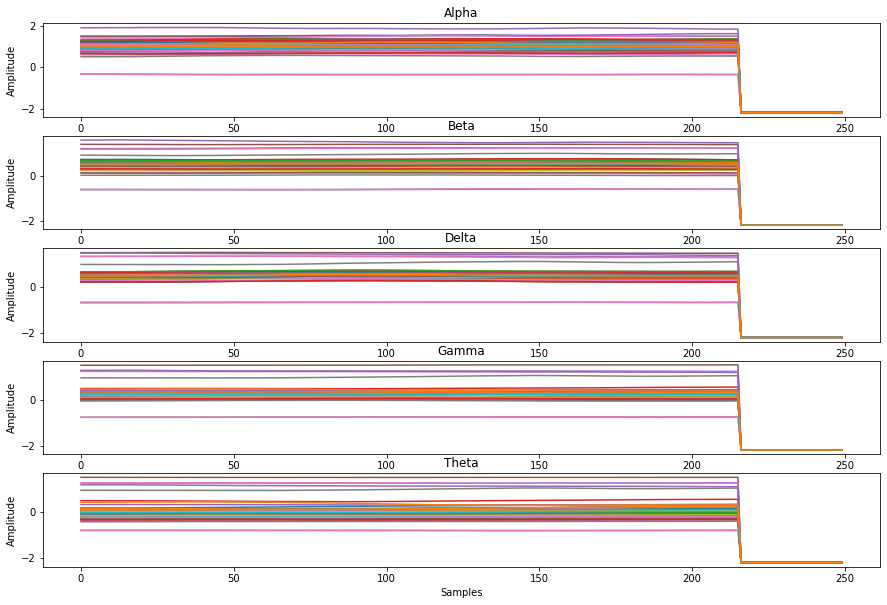

In [6]:
fig, a = plt.subplots(5, 1, squeeze= False, figsize= (15, 10))
titles = ['Alpha', 'Beta', 'Delta', 'Gamma', 'Theta']
for cnt in range(5):
  for i in range(len(test_data[5])):
    a[cnt][0].plot(range(len(test_data[5][i,:,cnt])), test_data[5][i,:,cnt])
  a[cnt][0].set_title(titles[cnt])
  a[cnt][0].set_xlabel('Samples')
  a[cnt][0].set_ylabel('Amplitude')

## Model Definitions

#### CNN Model


In [7]:
#Defining our CNN Model 

model = Sequential([
  Conv2D(filters= 64, kernel_size= 5, input_shape = (62,250,5), padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 64, kernel_size= 3, padding= 'same'),
  Conv2D(filters= 64, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2,strides = 2),
  #BatchNormalization(),
  Dropout(rate= 0.3),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = 2),
  #BatchNormalization(),
  Dropout(rate= 0.2),

  Conv2D(filters= 256, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  MaxPooling2D(pool_size= 2, strides = 2),
  #BatchNormalization(),
  Dropout(rate= 0.25),

  Conv2D(filters= 512, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides= 2),
  #BatchNormalization(),
  Dropout(rate= 0.3),
  
  Flatten(),

  Dense(512, activation= 'relu'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  #BatchNormalization(),
  Dropout(rate= 0.4),
  Dense(256, activation= 'relu'),
  #BatchNormalization(),
  Dropout(rate= 0.2),
  Dense(64, activation= 'relu'),
  #BatchNormalization(),
  Dense(3, activation= 'softmax')
])

model.compile(optimizer= keras.optimizers.Adam(learning_rate=9e-5), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 250, 64)       8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 250, 64)       36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 250, 64)       36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 125, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 125, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 31, 125, 128)      73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 31, 125, 128)      1

#### RNN Model

In [8]:
#Defining our RNN model 

model_rnn = Sequential([
  LSTM(units= 64, activation= 'tanh', input_shape= [1250, 62], return_sequences = True),
  Dropout(0.25),
  LSTM(units= 128, activation= 'tanh', return_sequences = True),
  Dropout(0.3),
  LSTM(units= 128, activation= 'tanh', return_sequences = True),
  Dropout(0.35),
  LSTM(units= 256, activation= 'tanh', return_sequences = True),
  Flatten(),

  Dense(256, activation= 'relu'),
  Dropout(0.25),
  Dense(128, activation= 'relu'),
  Dropout(0.35),
  Dense(64, activation= 'relu'),
  Dense(3, activation= 'softmax'),

])

model_rnn.compile(optimizer= keras.optimizers.Adam(learning_rate=5e-5), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1250, 64)          32512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1250, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1250, 128)         98816     
_________________________________________________________________
dropout_7 (Dropout)          (None, 1250, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1250, 128)         131584    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1250, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1250, 256)        

#### Hybrid Model

In [9]:
#Defining our Hybrid model 

model_hybrid = Sequential([
  Conv2D(filters= 64, kernel_size= 3, input_shape = (62,250,5), padding= 'same'), 
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2,strides = 2),
  BatchNormalization(),

  Conv2D(filters= 256, kernel_size= 3, padding= 'same'), 
  Conv2D(filters= 256, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = 2),
  BatchNormalization(),

  Conv2D(filters= 512, kernel_size= 3, padding= 'same'), 
  BatchNormalization(),

  Reshape((62, 15*512), input_shape= (15, 62, 512)), #Important to reshape so data passed to LSTM Layer correctly
  
  LSTM(units= 128, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 256, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 256, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  LSTM(units= 512, activation= 'tanh', return_sequences = True),
  BatchNormalization(),
  
  Flatten(),
  
  Dense(512, activation= 'relu'), 
  Dropout(0.25), 
  Dense(256, activation= 'relu'),
  Dropout(0.2),
  Dense(64, activation= 'relu'),
  Dense(3, activation= 'softmax')
])

model_hybrid.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-4), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
model_hybrid.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 250, 64)       2944      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 62, 250, 128)      73856     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 62, 250, 128)      147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 125, 128)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 125, 128)      512       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 31, 125, 256)      295168    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 125, 256)     

#### ViT Classifier Modified

In [50]:
learning_rate = 1e-3 #1e-3
#weight_decay = 0.0001
batch_size = 128 #128
num_epochs = 150
image_size = [15, 15]  # We'll resize input images to this size
patch_size = 3  # Size of the patches to be extract from the input images
num_patches = (image_size[0] // patch_size) * (image_size[1] // patch_size)
projection_dim = 64
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8 #8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
input_shape = (15, 15, 128)
num_classes= 3

In [51]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded



In [52]:
conv_block = Sequential([
  Conv2D(filters= 64, kernel_size= 3, input_shape = (62,250,5), padding= 'same', strides= (1,2)), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 64, kernel_size= 3, padding= 'same', strides= (1,2)),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2,strides = 2),
  #BatchNormalization(),
  Dropout(rate= 0.3),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 256, kernel_size= 3, padding= 'same'),
  Conv2D(filters= 512, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = 2),
  Dropout(rate= 0.2),

])

conv_block.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 62, 125, 64)       2944      
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 62, 63, 64)        36928     
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 62, 63, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 31, 31, 128)       0         
_________________________________________________________________
dropout_147 (Dropout)        (None, 31, 31, 128)       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 31, 31, 128)       147584    
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 31, 31, 256)     

In [53]:
conv_block_trial = Sequential([
  
  Conv2D(filters= 128, kernel_size= 3, input_shape = (62,265,5), padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2,strides = 2),
  #BatchNormalization(),
  Dropout(rate= 0.3),

  Conv2D(filters= 256, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 256, kernel_size= 3, padding= 'same'),
  Conv2D(filters= 256, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = 2),
  Dropout(rate= 0.2),


  Conv2D(filters= 512, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
  Conv2D(filters= 512, kernel_size= 3, padding= 'same'),
  Conv2D(filters= 512, kernel_size= 3, padding= 'same'),
  MaxPooling2D(pool_size= 2, strides = (1,2)),
  Dropout(rate= 0.25),
])

conv_block_trial.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 62, 265, 128)      5888      
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 62, 265, 128)      147584    
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 62, 265, 128)      147584    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 132, 128)      0         
_________________________________________________________________
dropout_149 (Dropout)        (None, 31, 132, 128)      0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 31, 132, 256)      295168    
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 31, 132, 256)    

In [54]:
def create_vit_classifier():
    inputs = layers.Input(shape= (62, 250, 5))
    features = conv_block(inputs)
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(features)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    outputs = layers.Softmax()(logits)
    # Create the Keras model.
    model_vit = keras.Model(inputs=inputs, outputs=outputs)
    return model_vit

def run_experiment(model_vit):

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )
    reduce_lr_exp = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=4, min_lr=1e-6)  

    history = model_vit.fit(
        x= train_data,
        y= train_labels_reshaped,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback, reduce_lr_exp],
    )

    model_vit.load_weights(checkpoint_filepath)
    _, accuracy = model_vit.evaluate(test_data, test_labels_reshaped)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

In [55]:
vit_classifier = create_vit_classifier()
vit_classifier.summary()

optimizer = keras.optimizers.Adam(
    learning_rate=learning_rate #, weight_decay=weight_decay
)

vit_classifier.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 62, 250, 5)] 0                                            
__________________________________________________________________________________________________
sequential_11 (Sequential)      (None, 15, 15, 512)  1736640     input_7[0][0]                    
__________________________________________________________________________________________________
patches_6 (Patches)             (None, None, 4608)   0           sequential_11[0][0]              
__________________________________________________________________________________________________
patch_encoder_6 (PatchEncoder)  (None, 25, 64)       296576      patches_6[0][0]                  
____________________________________________________________________________________________

## Training

#### CNN Training

In [16]:
#Training our CNN model using a learning rate annealer (Reduces LR on Plateaus)
reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-7) #patience = 5 and factor = 0.9

history = model.fit(
  train_data,
  train_labels_reshaped,
  batch_size = 64,
  epochs=100, 
  validation_data=(test_data, test_labels_reshaped),
  callbacks = [reduce_lr_cnn]
)

9/9 [==============================] - 41s 782ms/step - loss: 1.1033 - accuracy: 0.3800 - root_mean_squared_error: 0.4718 - val_loss: 1.0651 - val_accuracy: 0.3800 - val_root_mean_squared_error: 0.4638


#### LSTM Training

In [17]:
#Training our RNN model using a learning rate annealer (Reduces LR on Plateaus)
reduce_lr_rnn = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-6) #patience = 5 and factor = 0.9

history_rnn = model_rnn.fit(
  rnn_train,
  train_labels_reshaped,
  batch_size = 64,
  epochs=60,
  validation_data=(rnn_test, test_labels_reshaped),
  callbacks = [reduce_lr_rnn]
)

Epoch 1/60
9/9 [==============================] - 9s 450ms/step - loss: 1.0771 - accuracy: 0.4291 - root_mean_squared_error: 0.4656 - val_loss: 0.9506 - val_accuracy: 0.6000 - val_root_mean_squared_error: 0.4340
Epoch 2/60
9/9 [==============================] - 3s 296ms/step - loss: 0.9460 - accuracy: 0.5309 - root_mean_squared_error: 0.4339 - val_loss: 0.8039 - val_accuracy: 0.6200 - val_root_mean_squared_error: 0.3974
Epoch 3/60
4/9 [============>.................] - ETA: 1s - loss: 0.8811 - accuracy: 0.6094 - root_mean_squared_error: 0.4168

KeyboardInterrupt: ignored

#### Hybrid Training

In [29]:
#Training our Hybrid model using a learning rate annealer (Reduces LR on Plateaus)
reduce_lr_hybrid = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6) #patience = 5 and factor = 0.9

history_hybrid = model_hybrid.fit(
  train_data,
  train_labels_reshaped,
  batch_size = 32,
  epochs=60,
  validation_data=(test_data, test_labels_reshaped),
  callbacks = [reduce_lr_hybrid]
)

Epoch 1/60
10/18 [===============>..............] - ETA: 2s - loss: 0.5058 - accuracy: 0.8125 - root_mean_squared_error: 0.3088

KeyboardInterrupt: ignored

#### ViT Modified Training

In [56]:
history_exp = run_experiment(vit_classifier)

Epoch 1/150
4/4 [==============================] - 119s 3s/step - loss: 4.2157 - accuracy: 0.3434 - val_loss: 8.6187 - val_accuracy: 0.4182
Epoch 2/150
4/4 [==============================] - 1s 369ms/step - loss: 5.1140 - accuracy: 0.3980 - val_loss: 3.6238 - val_accuracy: 0.1455
Epoch 3/150
4/4 [==============================] - 1s 368ms/step - loss: 1.9251 - accuracy: 0.4323 - val_loss: 0.9162 - val_accuracy: 0.5636
Epoch 4/150
1/4 [======>.......................] - ETA: 1s - loss: 1.6944 - accuracy: 0.3203

KeyboardInterrupt: ignored

## Saving and Loading models

In [ ]:
# np.save("/content/drive/MyDrive/Colab Notebooks/test.npy", final_test)
# np.save("/content/drive/MyDrive/Colab Notebooks/test_label.npy", final_labels_reshaped)

In [ ]:
# model.save_weights("/content/drive/MyDrive/Colab Notebooks/cnn_best.h5")
# model_rnn.save_weights("/content/drive/MyDrive/Colab Notebooks/rnn_best.h5")
# model_hybrid.save_weights("/content/drive/MyDrive/Colab Notebooks/hybrid_best.h5")
# vit_classifier.save_weights("/content/drive/MyDrive/Colab Notebooks/vit_best.h5")

In [57]:
#NOTE: Loading pretrained models should only be done when the same data distribution (as shuffle is on) is also loaded otherwise you will get inflated results
model.load_weights("/content/drive/MyDrive/Colab Notebooks/cnn_best.h5")
model_rnn.load_weights("/content/drive/MyDrive/Colab Notebooks/rnn_best.h5")
model_hybrid.load_weights("/content/drive/MyDrive/Colab Notebooks/hybrid_best.h5")
vit_classifier.load_weights("/content/drive/MyDrive/Colab Notebooks/vit_best.h5")

## Results

#### Diagrams

In [ ]:
import matplotlib.pyplot as plt

epochs = len(history.history['loss'])
epochs_rnn = len(history_rnn.history['accuracy'])
epochs_hybrid = len(history_hybrid.history['accuracy'])
epochs_exp = len(history_exp.history['accuracy'])


plt.rcParams["figure.figsize"] = (30,10)
fig, a = plt.subplots(3, 4, squeeze= False)

#plt.figure(1)
a[0][0].plot(range(0,epochs), history.history['val_accuracy'], 'r', label = 'Test Accuracy')
a[0][0].plot(range(0,epochs), history.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][0].set_title('Accuracy CNN')
a[0][0].set_xlabel('Epochs')
a[0][0].set_ylabel('Accuracy')
a[0][0].legend()
#plt.show()

#plt.figure(2)
a[0][1].plot(range(0,epochs_rnn), history_rnn.history['val_accuracy'], 'r', label = 'Test Accuracy')
a[0][1].plot(range(0,epochs_rnn), history_rnn.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][1].set_title('Accuracy RNN')
a[0][1].set_xlabel('Epochs')
a[0][1].set_ylabel('Accuracy')
a[0][1].legend()

#plt.figure(3)
a[0][2].plot(range(0,epochs_hybrid), history_hybrid.history['val_accuracy'], 'r', label = 'Test Accuracy')
a[0][2].plot(range(0,epochs_hybrid), history_hybrid.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][2].set_title('Accuracy Hybrid')
a[0][2].set_xlabel('Epochs')
a[0][2].set_ylabel('Accuracy')
a[0][2].legend()

a[0][3].plot(range(0,epochs_exp), history_exp.history['val_accuracy'], 'r', label = 'Test Accuracy')
a[0][3].plot(range(0,epochs_exp), history_exp.history['accuracy'], 'y', label = 'Train Accuracy')
a[0][3].set_title('Accuracy ViT')
a[0][3].set_xlabel('Epochs')
a[0][3].set_ylabel('Accuracy')
a[0][3].legend()

#plt.figure(1)
a[1][0].plot(range(0,epochs - 40), history.history['val_loss'][0:60], 'r', label = 'Test Loss')
a[1][0].plot(range(0,epochs - 40), history.history['loss'][0:60], 'y', label = 'Train Loss')
a[1][0].set_title('Loss CNN')
a[1][0].set_xlabel('Epochs')
a[1][0].set_ylabel('Loss')
a[1][0].legend()
#plt.show()

#plt.figure(2)
a[1][1].plot(range(0,epochs_rnn), history_rnn.history['val_loss'], 'r', label = 'Test Loss')
a[1][1].plot(range(0,epochs_rnn), history_rnn.history['loss'], 'y', label = 'Train Loss')
a[1][1].set_title('Loss RNN')
a[1][1].set_xlabel('Epochs')
a[1][1].set_ylabel('Loss')
a[1][1].legend()

#plt.figure(3)
a[1][2].plot(range(0,epochs_hybrid), history_hybrid.history['val_loss'], 'r', label = 'Test Loss')
a[1][2].plot(range(0,epochs_hybrid), history_hybrid.history['loss'], 'y', label = 'Train Loss')
a[1][2].set_title('Loss Hybrid')
a[1][2].set_xlabel('Epochs')
a[1][2].set_ylabel('Loss')
a[1][2].legend()

a[1][3].plot(range(0,epochs_exp), history_exp.history['val_loss'], 'r', label = 'Test Loss')
a[1][3].plot(range(0,epochs_exp), history_exp.history['loss'], 'y', label = 'Train Loss')
a[1][3].set_title('Loss ViT')
a[1][3].set_xlabel('Epochs')
a[1][3].set_ylabel('Loss')
a[1][3].legend()

#plt.figure(1)
a[2][0].plot(range(0,epochs - 40), history.history['lr'][0:60], 'r', label = 'Test Learning rate')
a[2][0].set_title('Learning rate CNN')
a[2][0].set_xlabel('Epochs')
a[2][0].set_ylabel('Learning rate')
a[2][0].legend()
#plt.show()

#plt.figure(2)
a[2][1].plot(range(0,epochs_rnn), history_rnn.history['lr'], 'r', label = 'Test Learning rate')
a[2][1].set_title('Learning rate RNN')
a[2][1].set_xlabel('Epochs')
a[2][1].set_ylabel('Learning rate')
a[2][1].legend()

#plt.figure(3)
a[2][2].plot(range(0,epochs_hybrid), history_hybrid.history['lr'], 'r', label = 'Test Learning rate')
a[2][2].set_title('Learning rate Hybrid')
a[2][2].set_xlabel('Epochs')
a[2][2].set_ylabel('Learning rate')
a[2][2].legend()

a[2][3].plot(range(0,epochs_exp), history_exp.history['lr'], 'r', label = 'Test Learning rate')
a[2][3].set_title('Learning rate ViT')
a[2][3].set_xlabel('Epochs')
a[2][3].set_ylabel('Learning rate')
a[2][3].legend()
#plt.savefig('LR.eps', format='eps')

plt.show()

#### Metrics 

In [58]:
#Calculating Metrics, Confusion Matrices and Classification Reports
his = model.evaluate(x= final_test, y = final_labels_reshaped)
accuracy = his[1]
final_preds = np.empty([3, 75])
pred_labels = np.argmax(model.predict(final_test), axis=-1)

final_rnn_test = final_test.reshape(75, 62, -1)
final_rnn_test = np.transpose(final_rnn_test, (0,2,1))

his_rnn = model_rnn.evaluate(x= final_rnn_test, y = final_labels_reshaped)
accuracy_rnn = his_rnn[1]
pred_labels_rnn = np.argmax(model_rnn.predict(final_rnn_test), axis=-1)


his_hybrid = model_hybrid.evaluate(x= final_test, y = final_labels_reshaped)
accuracy_hybrid = his_hybrid[1]
pred_labels_hybrid = np.argmax(model_hybrid.predict(final_test), axis=-1)

his_exp = vit_classifier.evaluate(x= final_test, y= final_labels_reshaped)
accuracy_exp = his_exp[1]
pred_labels_exp = np.argmax(vit_classifier.predict(final_test), axis=-1)

final_preds[0,:] = pred_labels
final_preds[1,:] = pred_labels_rnn
final_preds[2,:] = pred_labels_hybrid
#final_preds[1,:] = pred_labels_exp

#Implementing Ensemble

ensemble_predictions = []
itr = 0
for i in range (0,75):
  itr += 1
  unique, counts = np.unique(final_preds[:,i], return_counts=True)
  if len(unique) == 3:
    ensemble_predictions.append(int(final_preds[1,i]))
  else:
    max = np.max(counts)
    index = np.unravel_index(np.argmax(counts), counts.shape)
    pred = unique[index]
    ensemble_predictions.append(int(pred))

accuracy_ensemble = sklearn.metrics.accuracy_score(cf_labels, ensemble_predictions)

cf_cnn = sklearn.metrics.confusion_matrix(cf_labels, pred_labels, labels = [2,0,1])
cf_rnn = sklearn.metrics.confusion_matrix(cf_labels, pred_labels_rnn, labels = [2,0,1])
cf_hybrid = sklearn.metrics.confusion_matrix(cf_labels, pred_labels_hybrid, labels = [2,0,1])
cf_exp = sklearn.metrics.confusion_matrix(cf_labels, pred_labels_exp, labels = [2,0,1])
cf_ensemble = sklearn.metrics.confusion_matrix(cf_labels, ensemble_predictions, labels = [2,0,1])
cf = sklearn.metrics.confusion_matrix(cf_labels, pred_labels, labels= [2,0,1])

cr = sklearn.metrics.classification_report(cf_labels, pred_labels, labels= [2,0,1])
cr_rnn = sklearn.metrics.classification_report(cf_labels, pred_labels_rnn, labels= [2,0,1])
cr_hybrid = sklearn.metrics.classification_report(cf_labels, pred_labels_hybrid, labels= [2,0,1])
cr_exp = sklearn.metrics.classification_report(cf_labels, pred_labels_exp, labels = [2,0,1])
cr_ensemble = sklearn.metrics.classification_report(cf_labels, ensemble_predictions, labels= [2,0,1])

mcc = sklearn.metrics.matthews_corrcoef(cf_labels, pred_labels)
mcc_rnn = sklearn.metrics.matthews_corrcoef(cf_labels, pred_labels_rnn)
mcc_hybrid = sklearn.metrics.matthews_corrcoef(cf_labels, pred_labels_hybrid)
mcc_ensemble = sklearn.metrics.matthews_corrcoef(cf_labels, ensemble_predictions) 
mcc_exp = sklearn.metrics.matthews_corrcoef(cf_labels, pred_labels_exp)

print("\n", "Accuracy of CNN: " + str(accuracy), "Accuracy of RNN: " + str(accuracy_rnn), "Accuracy of Hybrid Model: " + str(accuracy_hybrid), "Accuracy ViT: " + str(accuracy_exp), "Accuracy Ensemble: " + str(accuracy_ensemble), "\n", "Confusion Matrix CNN: ", str(cf), "Confusion Matrix RNN: ", str(cf_rnn), "Confusion Matrix Hybrid: ", str(cf_hybrid), "Confusion Matrix ViT: ", str(cf_exp), "Confusion Matrix Ensemble: ", str(cf_ensemble), "\n", "Classification Report CNN: ", str(cr), "Classification Report RNN: ", str(cr_rnn),  "Classification Report Hybrid: ", str(cr_hybrid), "Classification Report ViT: ", str(cr_exp), "Classification Report Ensemble: ", str(cr_ensemble), sep= '\n')
print(f'MCC CNN: {mcc}\n MCC RNN: {mcc_rnn}\n MCC Hybrid: {mcc_hybrid}\n MCC ViT: {mcc_exp}\n MCC Ensemble: {mcc_ensemble}')


#Use below code to save model and weights permanently


# with open('/content/drive/MyDrive/Colab Notebooks/best_cnn_data.npy', 'wb') as f:
#     np.save(f, data)
#     np.save(f, train_data)
#     np.save(f, test_data)
#     np.save(f, final_test)
# with open('/content/drive/MyDrive/Colab Notebooks/best_cnn_data.npy', 'rb') as f:
#     a = np.load(f)
#     b = np.load(f)
#     c = np.load(f)
#     d = np.load(f)
# print(np.testing.assert_allclose(d, final_test, err_msg= "FAIL"))

# model_json = model.to_json()
# with open("/content/drive/MyDrive/Colab Notebooks/cnn_best.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("/content/drive/MyDrive/Colab Notebooks/cnn_best.h5")
# print("Saved model to disk")

# # load json and create model
# json_file = open('/content/drive/MyDrive/Colab Notebooks/ensemble_best.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("/content/drive/MyDrive/Colab Notebooks/ensemble_best.h5")
# print("Loaded model from disk")

# loaded_model.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-4), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', 'categorical_accuracy', tf.keras.metrics.RootMeanSquaredError()])


3/3 [==============================] - 1s 198ms/step - loss: 0.0532 - accuracy: 0.9867


Accuracy of CNN: 0.9599999785423279
Accuracy of RNN: 0.8666666746139526
Accuracy of Hybrid Model: 0.9599999785423279
Accuracy ViT: 0.9866666793823242
Accuracy Ensemble: 0.9466666666666667


Confusion Matrix CNN: 
[[25  1  0]
 [ 1 28  0]
 [ 0  1 19]]
Confusion Matrix RNN: 
[[24  2  0]
 [ 3 26  0]
 [ 0  5 15]]
Confusion Matrix Hybrid: 
[[25  1  0]
 [ 1 28  0]
 [ 0  1 19]]
Confusion Matrix ViT: 
[[25  1  0]
 [ 0 29  0]
 [ 0  0 20]]
Confusion Matrix Ensemble: 
[[25  1  0]
 [ 1 28  0]
 [ 0  2 18]]


Classification Report CNN: 
              precision    recall  f1-score   support

           2       0.96      0.96      0.96        26
           0       0.93      0.97      0.95        29
           1       1.00      0.95      0.97        20

    accuracy                           0.96        75
   macro avg       0.96      0.96      0.96        75
weighted avg       0.96      0.96      0.96        75

Cl

## Ensemble

In [ ]:
pred = np.argmax(model.predict(train_data), axis=-1)
pred_rnn = np.argmax(model_rnn.predict(rnn_train), axis=-1)
pred_hybrid = np.argmax(model_hybrid.predict(train_data), axis=-1)
inputs = [pred, pred_rnn, pred_hybrid]
inputs = np.array(inputs).T

pred = np.argmax(model.predict(test_data), axis=-1)
pred_rnn = np.argmax(model_rnn.predict(rnn_test), axis=-1)
pred_hybrid = np.argmax(model_hybrid.predict(test_data), axis=-1)
inputs_test = [pred, pred_rnn, pred_hybrid]
inputs_test = np.array(inputs_test).T

model_stack = Sequential([
  #Input(shape= (3, 550)),
  Dense(128, 'relu', input_shape= (3,)),
  Dense(256, 'relu'),
  Dense(256, 'relu'),
  Dense(64, 'relu'),
  Dense(3, 'softmax')
])

model_stack.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-4), loss= keras.losses.categorical_crossentropy, metrics= 'accuracy')

model_stack.summary()

reduce_lr_stack = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6) #patience = 5 and factor = 0.9

history_stack = model_stack.fit(
  inputs,
  train_labels_reshaped,
  batch_size = 32,
  epochs=150,
  validation_data=(inputs_test, test_labels_reshaped),
  callbacks = [reduce_lr_stack]
)

In [ ]:
acc = model_stack.evaluate(x= final_preds.T, y= final_labels_reshaped)
print(f'Accuracy Ensemble MAX method: {accuracy_ensemble}, Accuracy Ensemble Stack method: {acc[1]}')

In [ ]:
cumul[0].append(accuracy)
cumul[1].append(accuracy_rnn)
cumul[2].append(accuracy_hybrid)
cumul[3].append(accuracy_ensemble)
cumul[4].append(acc[1])
cumul

In [ ]:
#model_rnn.save('saved_model/rnn_model')
#model_hybrid.save('saved_model/hybrid_model')
#!zip -r /content/saved_model.zip /content/saved_model

In [ ]:
"""
from sklearn.model_selection import StratifiedKFold
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []; cvscores_rnn = []; cvscores_hybrid = []; cvscores_ensemble = []
for train, test in kfold.split(data, labels_edited):
  # create model
  model = Sequential([
    Conv2D(filters= 64, kernel_size= 5, input_shape = (62,265,5), padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
    #Conv2D(filters= 64, kernel_size= 3, padding= 'same'),
    #Conv2D(filters= 64, kernel_size= 3, padding= 'same'),
    MaxPooling2D(pool_size= 2,strides = 2),
    BatchNormalization(),
    #Dropout(rate= 0.4),
    Conv2D(filters= 128, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
    #Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
    MaxPooling2D(pool_size= 2, strides = 2),
    BatchNormalization(),

    Conv2D(filters= 256, kernel_size= 3, padding= 'same'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling2D(pool_size= 2, strides = 2),
    BatchNormalization(),
    
    Conv2D(filters= 512, kernel_size= 3, padding= 'same'),
    MaxPooling2D(pool_size= 2, strides= 2),
    BatchNormalization(),
    
    Flatten(),

    Dense(512, activation= 'relu'), #kernel_regularizer=tf.keras.regularizers.l1(0.01), activity_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dense(256, activation= 'relu'),
    BatchNormalization(),
    Dense(64, activation= 'relu'),
    BatchNormalization(),
    Dense(3, activation= 'softmax')
  ])


  model_rnn = Sequential([
    LSTM(units= 128, activation= 'tanh', input_shape= [1325, 62], return_sequences = True),
    Dropout(0.25),
    LSTM(units= 128, activation= 'tanh', return_sequences = True),
    Dropout(0.3),
    LSTM(units= 256, activation= 'tanh', return_sequences = True),
    Dropout(0.35),
    LSTM(units= 256, activation= 'tanh', return_sequences = True),
    Flatten(),

    Dense(512, activation= 'relu'),
    Dropout(0.25),
    Dense(256, activation= 'relu'),
    Dropout(0.35),
    Dense(64, activation= 'relu'),
    Dense(3, activation= 'softmax'),

  ])

  model_hybrid = Sequential([
    Conv2D(filters= 64, kernel_size= 3, input_shape = (62,265,5), padding= 'same'), 
    Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
    #Conv2D(filters= 128, kernel_size= 3, padding= 'same'),
    MaxPooling2D(pool_size= 2,strides = 2),
    BatchNormalization(),

    Conv2D(filters= 256, kernel_size= 3, padding= 'same'), 
    Conv2D(filters= 256, kernel_size= 3, padding= 'same'),
    MaxPooling2D(pool_size= 2, strides = 2),
    BatchNormalization(),

    Conv2D(filters= 512, kernel_size= 3, padding= 'same'), 
    BatchNormalization(),

    Reshape((66, 15*512), input_shape= (15, 66, 512)), #Important to reshape so data passed to LSTM Layer correctly
    
    LSTM(units= 128, activation= 'tanh', return_sequences = True),
    BatchNormalization(),
    LSTM(units= 256, activation= 'tanh', return_sequences = True),
    BatchNormalization(),
    LSTM(units= 256, activation= 'tanh', return_sequences = True),
    BatchNormalization(),
    LSTM(units= 512, activation= 'tanh', return_sequences = True),
    BatchNormalization(),
    
    Flatten(),
    
    Dense(512, activation= 'relu'), 
    Dropout(0.25), 
    Dense(256, activation= 'relu'),
    Dropout(0.2),
    Dense(64, activation= 'relu'),
    Dense(3, activation= 'softmax')
  ])

  # Compile model
  model.compile(optimizer= keras.optimizers.Adam(learning_rate=9e-5), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
  model_rnn.compile(optimizer= keras.optimizers.Adam(learning_rate=5e-5), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
  model_hybrid.compile(optimizer= keras.optimizers.Adam(learning_rate=1e-4), loss= keras.losses.categorical_crossentropy, metrics= ['accuracy', tf.keras.metrics.RootMeanSquaredError()])
 
  # Fit the model
  reduce_lr_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7) #patience = 5 and factor = 0.9
  history = model.fit(
    train_data,
    train_labels_reshaped,
    batch_size = 64,
    epochs= 50, 
    validation_data=(test_data, test_labels_reshaped),
    callbacks = [reduce_lr_cnn]
  )
  
  reduce_lr_rnn = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=5, min_lr=1e-6) #patience = 5 and factor = 0.9
  history_rnn = model_rnn.fit(
    rnn_train,
    train_labels_reshaped,
    batch_size = 64,
    epochs= 60,
    validation_data=(rnn_test, test_labels_reshaped),
    callbacks = [reduce_lr_rnn]
  )
  
  reduce_lr_hybrid = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6) #patience = 5 and factor = 0.9
  history_hybrid = model_hybrid.fit(
    train_data,
    train_labels_reshaped,
    batch_size = 32,
    epochs=60,
    validation_data=(test_data, test_labels_reshaped),
    callbacks = [reduce_lr_hybrid]
  )
  # evaluate the model
  final_rnn_test = final_test.reshape(75, 62, -1)
  final_rnn_test = np.transpose(final_rnn_test, (0,2,1))

  scores = model.evaluate(x= final_test, y = final_labels_reshaped)
  scores_rnn = model_rnn.evaluate(x= final_rnn_test, y = final_labels_reshaped)
  scores_hybrid = model_hybrid.evaluate(x= final_test, y = final_labels_reshaped)

  #Ensemble
  final_preds = np.empty([3, 75])
  final_rnn_test = final_test.reshape(75, 62, -1)
  final_rnn_test = np.transpose(final_rnn_test, (0,2,1))
  
  pred_labels = np.argmax(model.predict(final_test), axis=-1)
  pred_labels_rnn = np.argmax(model_rnn.predict(final_rnn_test), axis=-1)
  pred_labels_hybrid = np.argmax(model_hybrid.predict(final_test), axis=-1)

  final_preds[0,:] = pred_labels
  final_preds[1,:] = pred_labels_rnn
  final_preds[2,:] = pred_labels_hybrid

  #Implementing Ensemble

  ensemble_predictions = []
  itr = 0
  for j in range (0,75):
    itr += 1
    unique, counts = np.unique(final_preds[:,j], return_counts=True)
    if len(unique) == 3:
      ensemble_predictions.append(int(final_preds[2,j]))
    else:
      max = np.max(counts)
      index = np.unravel_index(np.argmax(counts), counts.shape)
      pred = unique[index]
      ensemble_predictions.append(int(pred))

  accuracy_ensemble = sklearn.metrics.accuracy_score(cf_labels, ensemble_predictions)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
  print("%s: %.2f%%" % (model_rnn.metrics_names[1], scores_rnn[1]*100))
  print("%s: %.2f%%" % (model_hybrid.metrics_names[1], scores_hybrid[1]*100))
  cvscores.append(scores[1] * 100)
  cvscores_rnn.append(scores_rnn[1] * 100)
  cvscores_hybrid.append(scores_hybrid[1] * 100)
  cvscores_ensemble.append(accuracy_ensemble)
  """


In [ ]:
"""cvscores_ensemble
print(f'Accuracy: {np.mean(cvscores_ensemble)} STD: {np.std(cvscores_ensemble)}')
fig, ax = plt.subplots()
ax.set_title('Hide Outlier Points')
ax.boxplot(cvscores_ensemble, showfliers=True)"""